In [ ]:
import itertools

import numpy as np
from numpy import expand_dims

import matplotlib.pyplot as plt

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

from keras.utils import to_categorical

from keras.models import Sequential

from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Dropout

from keras.optimizers import Adam

from keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
# load the image
img = load_img('test.jpg')

plt.figure(figsize=(6, 4))
plt.title('Original Image')
# plot raw pixel data
plt.imshow(img)
# remove axis
plt.axis('off')

plt.savefig('original_image.jpg', orientation='landscape')

# show the figure
plt.show()

In [3]:
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.85, 1.15),
    zoom_range=(0.85, 1.15),
    horizontal_flip=True
    )
# prepare iterator
it = datagen.flow(samples, batch_size=1)

plt.figure(figsize=(24, 12))
plt.title('Augmented Images')
# generate samples and plot
for i in range(10):
  # define subplot
  plt.subplot(3, 4, i+1)
  # generate batch of images
  batch = it.next()
  # convert to unsigned integers for viewing
  image = batch[0].astype('uint8')
  # plot raw pixel data
  plt.imshow(image)
  # remove axis
  plt.axis('off')

plt.savefig('augmented_images.jpg', orientation='landscape')
# show the figure
plt.show()

In [4]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [5]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [6]:
print('Training Data: %d %d*%d*%d' % x_train.shape)
print('Test Data: %d %d*%d*%d' % x_test.shape)

Training Data: 50000 32*32*3
Test Data: 10000 32*32*3


In [7]:
argsort_idx = y_train.reshape(-1).argsort()
y_train = y_train[argsort_idx]
x_train = x_train[argsort_idx]

In [8]:
# cat
offset_cat = np.where(y_train==3)[0][0]
rm_idx_cat = np.random.choice(range(5000), 4500, replace=False)
rm_idx_cat = rm_idx_cat + offset_cat

# dog
offset_dog = np.where(y_train==5)[0][0]
rm_idx_dog = np.random.choice(range(5000), 4500, replace=False)
rm_idx_dog = rm_idx_dog + offset_dog

rm_idx = np.concatenate((rm_idx_cat, rm_idx_dog))
x_train = np.delete(x_train, rm_idx, axis=0)
y_train = np.delete(y_train, rm_idx, axis=0)

In [9]:
randomize = np.arange(y_train.shape[0])
np.random.shuffle(randomize)

x_train = x_train[randomize]
y_train = y_train[randomize]

In [10]:
print('Training Data: %d %d*%d*%d' % x_train.shape)
print('Test Data: %d %d*%d*%d' % x_test.shape)

Training Data: 41000 32*32*3
Test Data: 10000 32*32*3


# Train Classifier Without Data Augmentation

In [11]:
# input normalization
x_train_norm = x_train.astype('float32') / 255.0
x_test_norm = x_test.astype('float32') / 255.0

In [12]:
# convert output to one-hot encoding
y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)

In [15]:
# model design
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform',  padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)       

In [16]:
# compile model
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# fit model
es = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(x_train_norm, y_train_oh, epochs=100, batch_size=64,
                    validation_data=(x_test_norm, y_test_oh), verbose=2, callbacks=[es])

Epoch 1/100
641/641 - 45s - loss: 1.5602 - accuracy: 0.4777 - val_loss: 1.5482 - val_accuracy: 0.5009
Epoch 2/100
641/641 - 13s - loss: 1.0037 - accuracy: 0.6519 - val_loss: 1.3649 - val_accuracy: 0.5537
Epoch 3/100
641/641 - 13s - loss: 0.8145 - accuracy: 0.7199 - val_loss: 1.1971 - val_accuracy: 0.6289
Epoch 4/100
641/641 - 13s - loss: 0.7060 - accuracy: 0.7596 - val_loss: 1.0552 - val_accuracy: 0.6490
Epoch 5/100
641/641 - 13s - loss: 0.6272 - accuracy: 0.7872 - val_loss: 1.0888 - val_accuracy: 0.6732
Epoch 6/100
641/641 - 13s - loss: 0.5743 - accuracy: 0.8064 - val_loss: 0.9287 - val_accuracy: 0.7120
Epoch 7/100
641/641 - 13s - loss: 0.5241 - accuracy: 0.8234 - val_loss: 0.8233 - val_accuracy: 0.7235
Epoch 8/100
641/641 - 13s - loss: 0.4907 - accuracy: 0.8347 - val_loss: 0.8604 - val_accuracy: 0.7273
Epoch 9/100
641/641 - 13s - loss: 0.4626 - accuracy: 0.8456 - val_loss: 1.0804 - val_accuracy: 0.6799
Epoch 10/100
641/641 - 13s - loss: 0.4346 - accuracy: 0.8539 - val_loss: 0.7851 - 

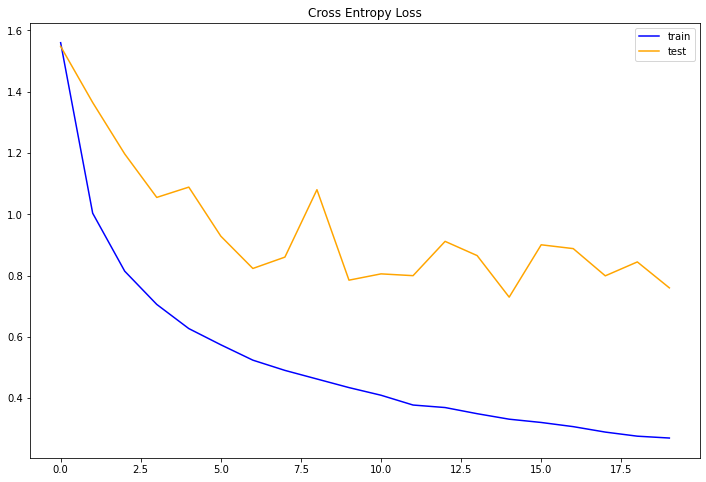

In [18]:
# plot loss
plt.figure(figsize=(12, 8))

plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.legend()

plt.savefig('loss_model_without_da.jpg', orientation='landscape')
plt.show()

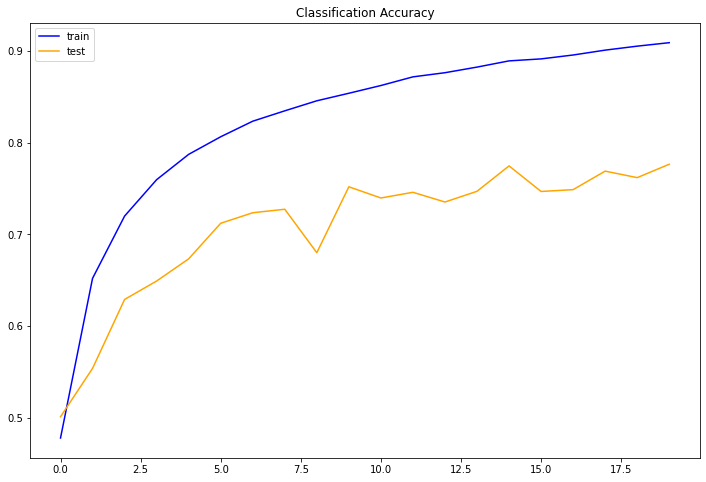

In [19]:
# plot accuracy
plt.figure(figsize=(12, 8))

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.legend()

plt.savefig('acc_model_without_da.jpg', orientation='landscape')
plt.show()

In [20]:
y_pred = model.predict(x_test_norm)

In [21]:
print(classification_report(y_test.reshape(-1), np.argmax(y_pred, axis=1), target_names=classes))

              precision    recall  f1-score   support

    airplane       0.82      0.89      0.86      1000
  automobile       0.95      0.89      0.92      1000
        bird       0.58      0.82      0.68      1000
         cat       0.71      0.27      0.40      1000
        deer       0.71      0.86      0.78      1000
         dog       0.82      0.38      0.51      1000
        frog       0.70      0.93      0.80      1000
       horse       0.78      0.89      0.83      1000
        ship       0.88      0.93      0.91      1000
       truck       0.89      0.90      0.90      1000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.76     10000
weighted avg       0.79      0.78      0.76     10000



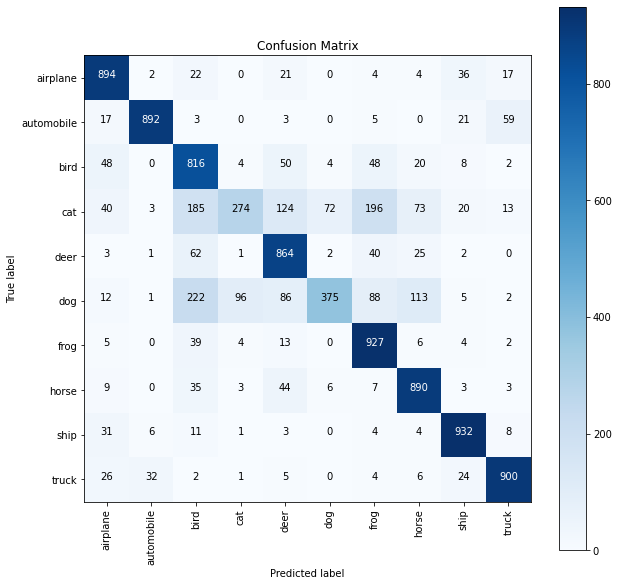

In [22]:
cm = confusion_matrix(y_test.reshape(-1), np.argmax(y_pred, axis=1))

plt.figure(figsize = (10, 10))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.savefig('cm_model_without_da.jpg')
plt.show()

# Train Classifier With Data Augmentation

In [23]:
# create image data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.85, 1.15),
    zoom_range=(0.85, 1.15),
    horizontal_flip=True
    )

# cat
# prepare iterator
it = datagen.flow(
    x_train[(y_train==3).reshape(-1)],
    batch_size=500
    )

x_cat = []
for _ in range(9):
  batch = it.next()
  x_cat.append(batch)

x_cat = np.array(x_cat).reshape(-1, x_train.shape[1], x_train.shape[2], x_train.shape[3])
x_train = np.concatenate((x_train, x_cat))
y_train = np.concatenate((y_train, np.full((4500, 1), 3, dtype=np.uint8)))

# dog
# prepare iterator
it = datagen.flow(
    x_train[(y_train==5).reshape(-1)],
    batch_size=500
    )

x_dog = []
for _ in range(9):
  batch = it.next()
  x_dog.append(batch)

x_dog = np.array(x_dog).reshape(-1, x_train.shape[1], x_train.shape[2], x_train.shape[3])
x_train = np.concatenate((x_train, x_dog))
y_train = np.concatenate((y_train, np.full((4500, 1), 5, dtype=np.uint8)))

In [24]:
randomize = np.arange(y_train.shape[0])
np.random.shuffle(randomize)

x_train = x_train[randomize]
y_train = y_train[randomize]

In [25]:
print('Training Data: %d %d*%d*%d' % x_train.shape)
print('Test Data: %d %d*%d*%d' % x_test.shape)

Training Data: 50000 32*32*3
Test Data: 10000 32*32*3


In [27]:
# input normalization
x_train_norm = x_train.astype('float32') / 255.0
x_test_norm = x_test.astype('float32') / 255.0

In [28]:
# convert output to one-hot encoding
y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)

In [29]:
# model design
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
# model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
# model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform',  padding='same'))
model.add(BatchNormalization())
# model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)       

In [30]:
# compile model
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
# fit model
es = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(x_train_norm, y_train_oh, epochs=100, batch_size=64,
                    validation_data=(x_test_norm, y_test_oh), verbose=2, callbacks=[es])

Epoch 1/100
782/782 - 18s - loss: 1.6201 - accuracy: 0.4399 - val_loss: 1.3477 - val_accuracy: 0.5463
Epoch 2/100
782/782 - 16s - loss: 1.0563 - accuracy: 0.6169 - val_loss: 1.1675 - val_accuracy: 0.5989
Epoch 3/100
782/782 - 16s - loss: 0.8732 - accuracy: 0.6836 - val_loss: 0.8871 - val_accuracy: 0.6908
Epoch 4/100
782/782 - 16s - loss: 0.7649 - accuracy: 0.7224 - val_loss: 0.8269 - val_accuracy: 0.7183
Epoch 5/100
782/782 - 16s - loss: 0.6925 - accuracy: 0.7490 - val_loss: 0.8669 - val_accuracy: 0.7217
Epoch 6/100
782/782 - 16s - loss: 0.6361 - accuracy: 0.7705 - val_loss: 0.7483 - val_accuracy: 0.7482
Epoch 7/100
782/782 - 16s - loss: 0.5929 - accuracy: 0.7864 - val_loss: 0.8175 - val_accuracy: 0.7342
Epoch 8/100
782/782 - 16s - loss: 0.5461 - accuracy: 0.8031 - val_loss: 0.6607 - val_accuracy: 0.7743
Epoch 9/100
782/782 - 16s - loss: 0.5128 - accuracy: 0.8159 - val_loss: 0.7564 - val_accuracy: 0.7599
Epoch 10/100
782/782 - 16s - loss: 0.4855 - accuracy: 0.8270 - val_loss: 0.7967 - 

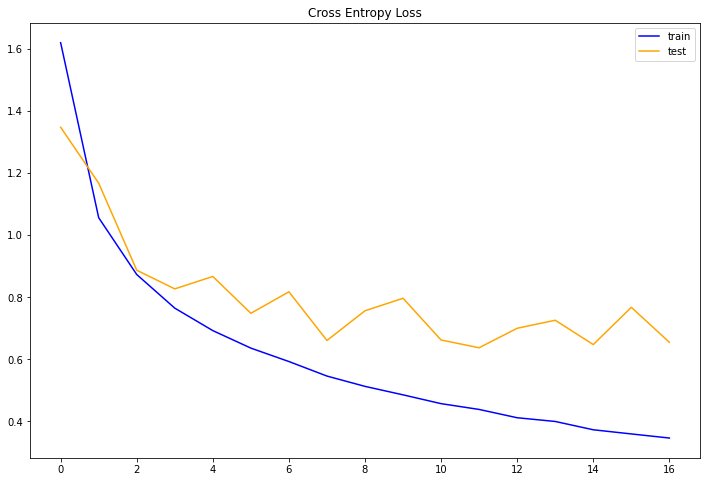

In [32]:
# plot loss
plt.figure(figsize=(12, 8))

plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.legend()

plt.savefig('loss_model_with_da.jpg', orientation='landscape')
plt.show()

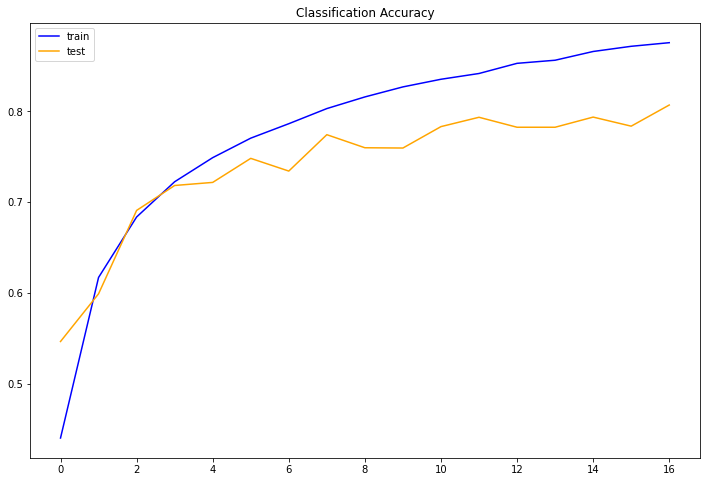

In [33]:
# plot accuracy
plt.figure(figsize=(12, 8))

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.legend()

plt.savefig('acc_model_with_da.jpg', orientation='landscape')
plt.show()

In [34]:
y_pred = model.predict(x_test_norm)

In [35]:
print(classification_report(y_test.reshape(-1), np.argmax(y_pred, axis=1), target_names=classes))

              precision    recall  f1-score   support

    airplane       0.87      0.85      0.86      1000
  automobile       0.92      0.91      0.92      1000
        bird       0.83      0.71      0.76      1000
         cat       0.70      0.49      0.58      1000
        deer       0.69      0.90      0.78      1000
         dog       0.81      0.55      0.65      1000
        frog       0.72      0.93      0.81      1000
       horse       0.82      0.89      0.85      1000
        ship       0.91      0.90      0.91      1000
       truck       0.84      0.94      0.89      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.80     10000
weighted avg       0.81      0.81      0.80     10000



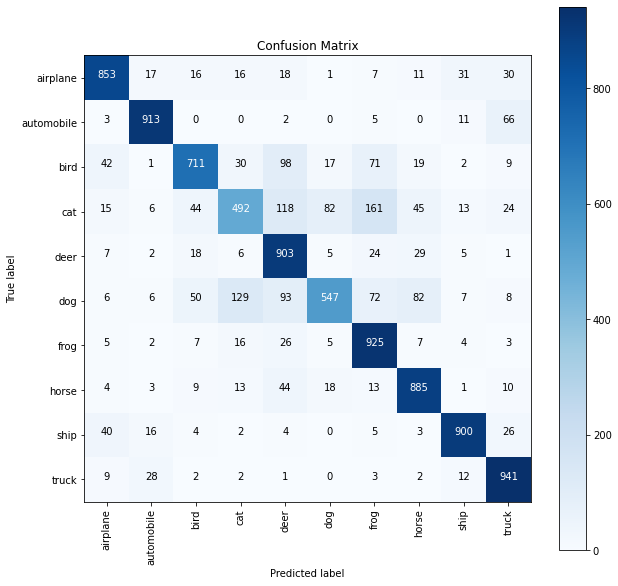

In [36]:
cm = confusion_matrix(y_test.reshape(-1), np.argmax(y_pred, axis=1))

plt.figure(figsize = (10, 10))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.savefig('cm_model_with_da.jpg', orientation='landscape')
plt.show()